# Title <a class="tocSkip">

# Goal <a class="tocSkip">

afljfaflfj 

# Exec Sum <a class="tocSkip">

afafa

# Imports <a class="tocSkip">

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# py modules
import acquire as a
import explore as e
import visual as viz
import model as m

from math import sqrt

# hypothesis testing
from scipy import stats
from scipy.stats import pearsonr, spearmanr, ttest_1samp, ttest_ind, chi2_contingency

# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
import sklearn.preprocessing
from sklearn.feature_selection import RFE
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

seed = 21

# Acquired <a class="tocSkip">

akfhakjhfahk

In [2]:
# Acquire Data
df = a.get_wine()

# Add Exploration columns
df = e.add_exploration_columns(df)

# Prepare <a class="tocSkip">

aljfalsjfaj

In [3]:
# Split Data
train, X_train, y_train, X_val, y_val, X_test, y_test = e.split_data(df,'quality')

# Scale Data
X_train_s,X_val_s,X_test_s = e.scale_minmax(X_train,X_val,X_test)

# Deep copy of scaled dataset with quality column added
train_scaled = e.copy_train(X_train_s, train)

# Dropping infinite values
X_train_s, X_val_s, X_test_s, y_train, y_val, y_test =\
m.drop_infinite(X_train_s, X_val_s, X_test_s, y_train, y_val, y_test)

# Explore <a class="tocSkip">

Questions: 
1. The proportion of acid to (alcohol + sugar) affects quality.
2. White and red wines’ quality is different
3. The proportion of acid to chlorides affects quality
4. Density affects the quality of wine

In [4]:
# Creating Cluster column
X_train_s, X_val_s, X_test_s = e.cluster_Xsets(X_train_s, X_val_s, X_test_s, ['alcohol','volatile_acidity','density','chlorides'])

##  Cluster Plots for Alcohol, Volatile Acidity, and Density <a class="tocSkip">


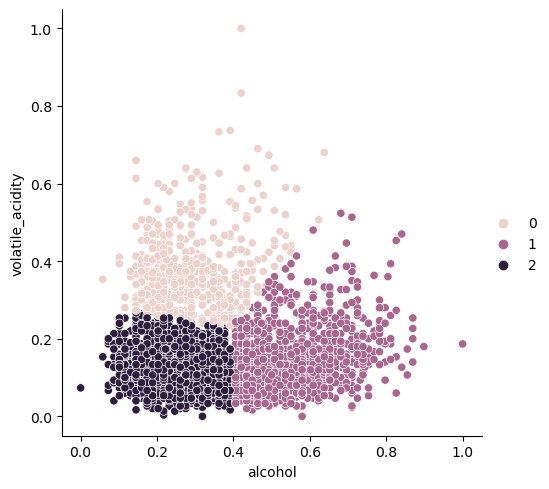

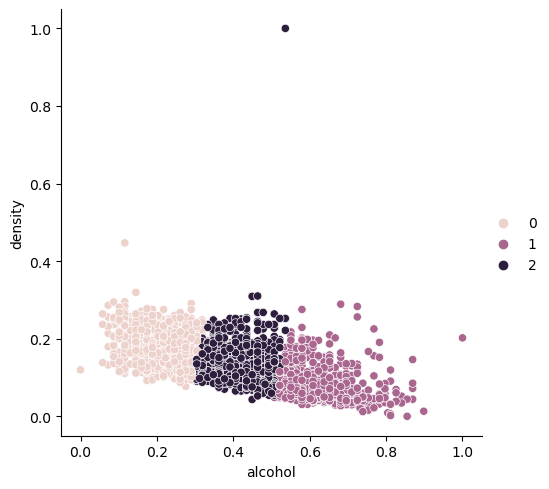

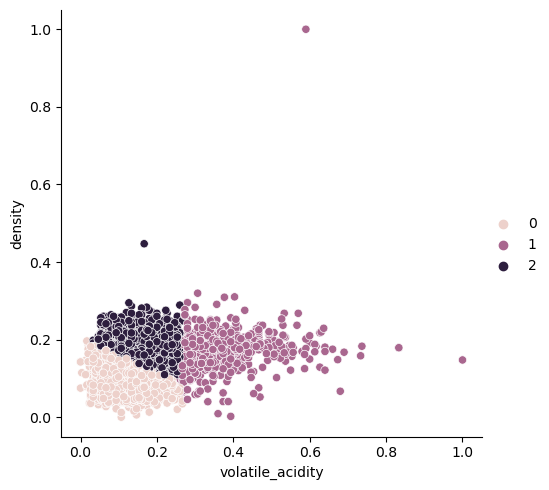

In [5]:
# Plot clusters
e.plot_clusters(X_train_s,'alcohol','volatile_acidity','density')

# Q1. The proportion of acid to (alcohol + sugar) affects quality. <a class="tocSkip">

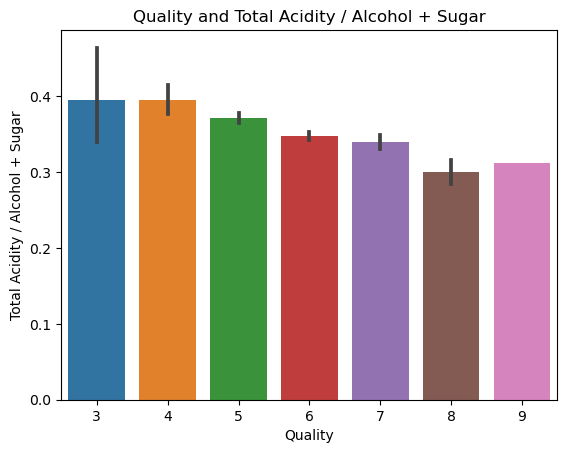

In [6]:
# Barplot of total acidity divided by alcohol+sugar
viz.barplot1(train)

### Takeaways:The higher the proportion of total acidity to alcohol and suger, the lower the quality <a class="tocSkip">

## Stats Test <a class="tocSkip">

In [7]:
# Spearman's Test
viz.spearman1(train_scaled)

Spearman's R Test Results
--------------------------
Correlation: -0.14
P-value: 2.3582308636003602e-17


# Q2. White and red wines’ quality is different <a class="tocSkip">

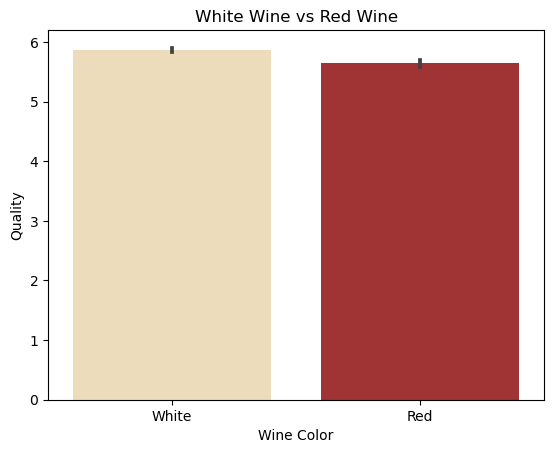

In [8]:
# Barplot of white wine vs red wine
viz.barplot2(train)

### Takeaways: White wine, on average, is of higher quality than red wine. <a class="tocSkip">

## Stats Test <a class="tocSkip">

In [9]:
# Chi Square test
viz.chi(train_scaled)

Chi-square Test Results
-----------------------
Chi value: 67.49
p-value: 1.3387911526612644e-12


# Q3. The proportion of acid to chlorides affects quality <a class="tocSkip">

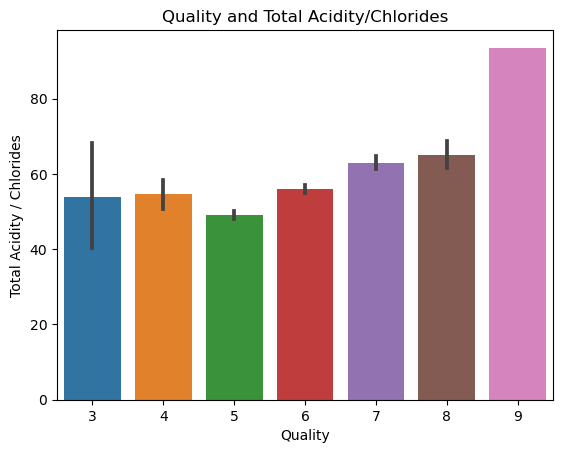

In [10]:
# Barplot of total acidity divided by chlorides
viz.barplot3(train)

### Takeaways: the higher the proportion of total acidity and chlorides, the higher the quality. <a class="tocSkip">

## Stats Test <a class="tocSkip">

In [11]:
# Spearman's R test
viz.spearman2(train_scaled)

Spearman's R Test Results
--------------------------
Correlation: 0.26
P-value: 1.0376033510870366e-58


# Q4. Density affects the quality of wine <a class="tocSkip">

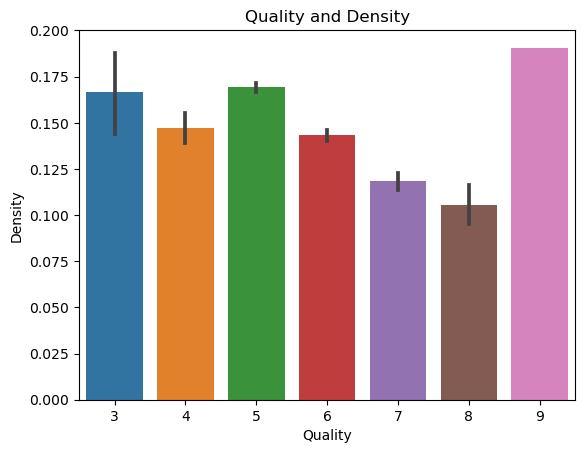

In [12]:
# Barplot
viz.barplot4(train_scaled)

### Takeaways: Except for a quality of 9, the higher the density, the lower the quality. <a class="tocSkip">

## Stats Test <a class="tocSkip">

In [13]:
# Pearson R test
viz.pearsonr(train_scaled)

Pearson's R Test Results
-------------------------
Correlation: -0.14
P-value: 1.2129165060754792e-17


## Explore Summary <a class="tocSkip">

<div class="alert alert-success">
Blah blah blah
</div>

# Modeling <a class="tocSkip">

In [18]:
model = m.run_models(X_train_s, X_val_s, X_test_s, y_train, y_val, 'quality').sort_values('rmse_val')
model.sort_values('difference', ascending=False)

,model,rmse_train,rmse_val,difference
1,lm,0.730056,0.737381,-0.007325
12,tweedie1_pf3,0.762503,0.772662,-0.010159
8,tweedie1_pf2,0.781530,0.794016,-0.012486
11,tweedie0_pf3,0.803920,0.816685,-0.012765
7,tweedie0_pf2,0.834746,0.847992,-0.013245
4,tweedie1,0.834163,0.848619,-0.014456
3,tweedie0,0.865419,0.881080,-0.015661
0,baseline,0.867745,0.883757,-0.016012
2,lass,0.867745,0.883757,-0.016012
6,lass_pf2,0.867745,0.883757,-0.016012


# Comparing Models<a class="tocSkip">

<div class="alert alert-success">
Blah blah blah
</div>

# Conclusion <a class="tocSkip">

<div class="alert alert-success">
Blah blah blah
</div>